In [74]:
%matplotlib inline

import re
import numpy
import json
import time
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
main_folder = "/Users/ofek/PCA_CF/compareToDva/"
model_file_path = main_folder + "modelFile_main_201811060700.json"
model_low_file_path = main_folder + "modelFile_main_201811060700_low.json"
# choose the number of values per ad in the new model
K = 668

tmp_pca_matrix_file_path = main_folder + "tmp_pca_matrix.tmp"
tmp_low_matrix_file_path = main_folder + "tmp_low_matrix.tmp"

ad_vec_pattern = re.compile(r".*\"creative_id\.([0-9]*)\":\[(.*)\].*")  # for ad vectors count
ad_vec_sub_pattern = re.compile(r"(.*\"creative_id\.[0-9]*\":\[).*(\].*)")  # for vector substitution

In [99]:
# *******
# methods
# =======

def get_user_features(model_file_path):
    with open(model_file_path, 'r') as model_file:
        line_list = []
        ok_to_write = False
        for line in model_file:
            if "\"user\":" in line:
                line_list.append("{")
                ok_to_write = True
            elif "\"ad\":" in line:
                line_list.pop()
                line_list.append("}")
                ret = ''.join(line_list)
                return json.loads(''.join(ret))
            else:
                if ok_to_write:
                    line_list.append(line)
    return None


def getUserFeaturesVector(label_vectors, row_idx, user_features):
    labels_count = 0
    for feature_name in user_features:
        label_count = 0
        feature = user_features[feature_name]
        # if the feature contains any label with "NEUTRAL" skip it, it will be added later
        if len([p for p in feature.keys() if "NEUTRAL" in p]) > 0:
            continue
        for label in feature:
            label_vectors[row_idx] = numpy.array(feature[label]);
            row_idx += 1
            label_count += 1
        print("Done for feature_name [" + feature_name + "] label_count [" + str(label_count) + "]")
        labels_count += label_count
    return labels_count


# for features that are added together before multiplication
def getListUserFeatureVector(label_vectors, row_idx, user_features, feature_name, sub_feature_name = None):
    labels_count = 0
    list_feature = user_features[feature_name]
    if len(list_feature) <= 0:
        raise Exception("Error with feature_name [" + feature_name + "]")
    if sub_feature_name is not None:
        # filter out any label that does not contain the sub_feature_name
        list_feature = { k: v for k, v in list_feature.items() if sub_feature_name in k }
        if len(list_feature) <= 0:
            raise Exception("Error with feature_name [" + feature_name + "] and sub_feature_name [" + sub_feature_name + "]")

    # get NEUTRAL vector
    neutral_label_map = { k: v for k, v in list_feature.items() if "NEUTRAL" in k }
    if len(neutral_label_map) is not 1:
        raise Exception("Error with feature_name [" + feature_name + "] and sub_feature_name [" + sub_feature_name + "]")
    neutral_label = list(neutral_label_map.keys())[0]
    neutral_label_vec = numpy.array(neutral_label_map[neutral_label])
    # remove neutral label from list_feature
    list_feature = { k: v for k, v in list_feature.items() if "NEUTRAL" not in k }

    for label in list_feature:
        list_feature_vector = numpy.array(list_feature[label])
        list_feature_vector = numpy.add(list_feature_vector, neutral_label_vec)
        label_vectors[row_idx] = list_feature_vector
        row_idx += 1
        labels_count += 1

    print("Done for feature_name [" + feature_name + "] sub_feature_name [" + str(sub_feature_name) + "] labels_count [" + str(labels_count) + "]")
    return labels_count


def generate_label_vectors_matrix(model_file_path):
    user_features = get_user_features(model_file_path)
    max_num_of_rows = numpy.sum([len(user_features[feature]) for feature in user_features])
    print("max_num_of_rows [" + str(max_num_of_rows) + "]")
    # count how many NEUTRAL vectors there are
    num_of_neutral_vectors = 0
    for feature_name in user_features:
        feature = user_features[feature_name]
        num_of_neutral_vectors += len([p for p in feature.keys() if "NEUTRAL" in p])
    label_vectors_matrix = numpy.zeros(shape=(max_num_of_rows - num_of_neutral_vectors, 970))

    row_idx = 0
    row_idx += getUserFeaturesVector(label_vectors_matrix, row_idx, user_features)
    row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "externalFeature", "exp5_allMappi")
    row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "externalFeature", "exp1_userCategory")
    row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "yic_mv")
    row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "yct_c_mv_w")
    row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "userSignal")

    return label_vectors_matrix


In [100]:
# *********
# algorithm
# =========

# get number of ads in the model
num_of_ads = 0
with open(model_file_path, 'r') as model_file:
    for line in model_file:
        if ad_vec_pattern.match(line):
            num_of_ads += 1

print("ad num [" + str(num_of_ads) + "]")

# prepare the matrix with all the ad vectors in rows
X = numpy.zeros(shape=(num_of_ads, 970))
creative_ids = []
with open(model_file_path, 'r') as model_file:
    ad_idx = 0
    for line in model_file:
        m = ad_vec_pattern.match(line)
        if m:
            creative_id = m.group(1)
            creative_ids.append(creative_id)
            X[ad_idx] = numpy.fromstring(m.group(2), sep=",")
            ad_idx += 1

assert ad_idx == num_of_ads
assert numpy.sum(X[:,968]) == 0  # all values in col are 0
assert numpy.sum(X[:,969]) == X.shape[0]  # all values in col are 1

# generate the label vectors
label_vectors_matrix = generate_label_vectors_matrix(model_file_path)

# the last col is the label vector bias and is equal in all label vectors
# argmax - returns the index of the maximum value along the axis
# the bias is taken from one of the "day" user feature vector (any of them)
user_vector_bias = label_vectors_matrix[(label_vectors_matrix[:, 969] != 1.0).argmax(axis=0), 969]

# all values in col are user_vector_bias
# 8 amounts to the number of "day" feature labels - (1-7) + 1 UNKNOWN label. located here label_vectors_matrix[15460:15470,:]
# Haifa choose to add the bias in the "day" feature. Since it is only in one feature, any user vector that is generated will have
# the bias in the last value of the vector.
assert numpy.sum(label_vectors_matrix[:,969] != 1.0) == 8

# calculate PCA
# 1) append the matrices
X_for_pca = numpy.concatenate((X, label_vectors_matrix), axis=0)

assert X_for_pca.shape[1] == 970

# 2) remove the last two cols which contain 0 and 1 for bias
X_for_pca = numpy.delete(X_for_pca, 969, 1)  # all ones
X_for_pca = numpy.delete(X_for_pca, 968, 1)  # all zeros

# 3) calculate the covariance matrix Sigma
Sigma = numpy.matmul(numpy.transpose(X_for_pca), X_for_pca) / X_for_pca.shape[0]  # (1/|rows in X|) * (X' * X)
UX, SX, _ = numpy.linalg.svd(Sigma)  # [U S V] = svd(Sigma);

print("Done")


ad num [260042]
max_num_of_rows [28072]
Done for feature_name [day] label_count [8]
Done for feature_name [local_hour] label_count [25]
Done for feature_name [sectionId] label_count [11634]
Done for feature_name [state] label_count [3671]
Done for feature_name [age] label_count [126]
Done for feature_name [gender] label_count [4]
Done for feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels_count [2924]
Done for feature_name [externalFeature] sub_feature_name [exp1_userCategory] labels_count [20]
Done for feature_name [yic_mv] sub_feature_name [None] labels_count [96]
Done for feature_name [yct_c_mv_w] sub_feature_name [None] labels_count [1035]
Done for feature_name [userSignal] sub_feature_name [None] labels_count [8524]


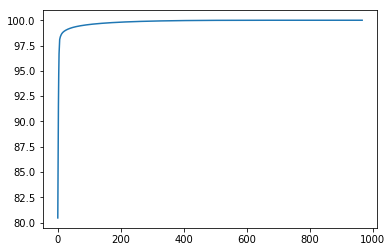

In [66]:
# plot the variance preservance
sx_all = numpy.sum(SX)
df_map = {
    'k': range(1, 968),
    'variance': [((numpy.sum(SX[0:k]) * 100.0) / sx_all) for k in range(1, 968)]
}
sx_df = pd.DataFrame.from_dict(df_map)
#print(sx_df)
#sx_df.plot(x='k', y='variance', style='o')
plt.plot(sx_df['variance'])

In [67]:
# use PCA UX matrix to reduce the dimension of the ad vectors
# calculate preserved variance percentage for declaration in the model file
preserved_variance_pct = (numpy.sum(SX[0:K]) * 100.0) / numpy.sum(SX)
# reduce the dimension of the ad vectors
X_low = numpy.matmul(X[:, 0:968], UX[:, 0:K])  # Z = X * U(:, 1:K);

assert X_low.shape[1] == K
assert X_low.shape[0] == X.shape[0]

# add a ones col for user vector bias addition
X_low = numpy.concatenate((X_low, numpy.ones((X_low.shape[0], 1))), axis=1)

assert X_low.shape[1] == (K + 1)
assert X_low.shape[0] == X.shape[0]
assert X_low.shape[0] == num_of_ads

In [ ]:
# **********************************
# write the new model to a json file
# ==================================

# copy all the lines in the file
open(model_low_file_path, 'w').close()  # delete output file content
open(tmp_pca_matrix_file_path, 'w').close()  # delete the content of the tmp pca matrix file
open(tmp_low_matrix_file_path, 'w').close()  # delete the content of the tmp X_low matrix file
with open(model_file_path, 'r') as model_file, open(model_low_file_path, 'a') as model_low_file:
    # pca data is inserted before the feature vectors section starts
    while True:
        line = model_file.readline()
        if "\"user\":{\n" in line:
            break
        model_low_file.write(line)
    model_low_file.write("\"pca\":{\n")
    model_low_file.write("\"usedVecDim\": \"" + str(K) + "\",\n")
    model_low_file.write("\"preservedVariancePct\": \"" + str(preserved_variance_pct) + "\",\n")
    model_low_file.write("\"userVectorBias\": \"" + str(user_vector_bias) + "\",\n")
    model_low_file.write("\"UX\": \n")
    with open(tmp_pca_matrix_file_path, 'w') as tmp_pca_matrix_file:
        numpy.savetxt(tmp_pca_matrix_file, UX, delimiter=",", fmt="%1.6E")
    model_low_file.write("[\n")
    with open(tmp_pca_matrix_file_path, 'r') as tmp_pca_matrix_file:
        count = 0
        for pca_matrix_row in tmp_pca_matrix_file:
            count += 1
            model_low_file.write("[" + pca_matrix_row.strip().replace("E-0", "E-").replace("E+0", "E+") + "]" + (",\n" if count < 968 else "\n"))
    # delete the tmp file
    open(tmp_pca_matrix_file_path, 'w').close()
    model_low_file.write("]\n")
    model_low_file.write("},\n")  # close for pca section

    # feature vectors remain as they are (original dimension of 970)
    model_low_file.write("\"user\":{\n")
    while True:
        line = model_file.readline()
        model_low_file.write(line)
        if "\"ad\":" in line:
            break

    # write all the new lower dimension creatives' vectors
    # in bash: `cat lfmModel12_201809010945.json.gz | gzip -cd | grep "\"creative_id\.[0-9]*\":\[" | sed -E -e "s/.*\"creative_id\.([0-9]*)\":\[(.*)\].*/\1 \2/g" | tr ',' ' ' > lfmModel12_201809010945.m`

    with open(tmp_low_matrix_file_path, 'w') as tmp_low_matrix_file:
        numpy.savetxt(tmp_low_matrix_file, X_low, delimiter=",", fmt="%1.6E")
    with open(tmp_low_matrix_file_path, 'r') as tmp_low_matrix_file:
        ad_idx = 0
        while True:
            line = model_file.readline()
            if not line:
                assert not tmp_low_matrix_file.readline()
                break
            m = ad_vec_sub_pattern.match(line)
            if m:
                X_low_row = tmp_low_matrix_file.readline()
                X_low_row = X_low_row.replace('\n', '').replace(' ', '').replace("E-0", "E-").replace("E+0", "E+")
                new_ad_vector_line = m.group(1) + X_low_row + m.group(2) + "\n"
                # TODO: sanity, make sure the line is correct using the `ad_vec_pattern` regex
                ms = ad_vec_pattern.match(new_ad_vector_line)
                if ms:
                    ad_idx += 1
                    model_low_file.write(new_ad_vector_line)
                else:
                    print "ERROR with line [" + new_ad_vector_line + "]"
            else:
                model_low_file.write(line)

    # delete the tmp file
    open(tmp_low_matrix_file_path, 'w').close()

print("Done in [" + str(int(time.time()) - start_time_sec) + "] sec")
print("Number of written ads/number of ads in original model [" + str(ad_idx) + "/" + str(num_of_ads) + "]")


In [98]:
# ************************************
# generate random user profile vectors
# ====================================

num_of_profiles_to_generate = 210

def get_user_features_string():
    with open(model_file_path, 'r') as model_file:
        line_list = []
        ok_to_write = False
        for line in model_file:
            if "\"user\":" in line:
                line_list.append("{")
                ok_to_write = True
            elif "\"ad\":" in line:
                line_list.pop()
                line_list.append("}")
                ret = ''.join(line_list)
                return ''.join(ret)
            else:
                if ok_to_write:
                    line_list.append(line)


def coin_toss(p=.5):
    return True if random.random() < p else False


def get_user_features_vector(user_features):
    feature_vector = numpy.ones(970)
    for feature_name in user_features:
        feature = user_features[feature_name]
        # if the feature contains any label with "NEUTRAL" skip it
        if len([p for p in feature.keys() if "NEUTRAL" in p]) > 0:
            continue;
        rand_index = random.randint(0, len(feature.keys()) - 1)
        chosen_label = list(feature)[rand_index]
        print("feature_name [" + feature_name + "] label [" + chosen_label + "]")
        feature_vector = numpy.multiply(feature_vector, feature[chosen_label])

    #print numpy.array2string(feature_vector, max_line_width=numpy.inf, separator=' ',suppress_small=True)
    return feature_vector


# for features that are added together before multiplication
def getListUserFeatureVector(user_features, feature_name, sub_feature_name = None, maxNumOfLabels = 100):
    considered_labels = []
    list_feature_vector = numpy.zeros(970)
    list_feature = user_features[feature_name]
    if len(list_feature) <= 0:
        raise Exception("Error with feature_name [" + feature_name + "]")
    if sub_feature_name is not None:
        # filter out any label that does not contain the sub_feature_name
        list_feature = { k: v for k, v in list_feature.items() if sub_feature_name in k }
        if len(list_feature) <= 0:
            raise Exception("Error with feature_name [" + feature_name + "] and sub_feature_name [" + sub_feature_name + "]")

    # add NEUTRAL vector
    neutral_label_map = { k: v for k, v in list_feature.items() if "NEUTRAL" in k }
    if len(neutral_label_map) is not 1:
        raise Exception("Error with feature_name [" + feature_name + "] and sub_feature_name [" + sub_feature_name + "]")
    neutral_label = list(neutral_label_map.keys())[0]
    considered_labels.append(neutral_label)
    list_feature_vector = numpy.add(list_feature_vector, numpy.array(list_feature[neutral_label]))
    # remove neutral label from list_feature
    list_feature = { k: v for k, v in list_feature.items() if "NEUTRAL" not in k }

    # choose UNKNOWN
    if coin_toss(0.05):
        # in this case only UNKNOWN (and NEUTRAL) should be picked
        unknown_label_map = { k: v for k, v in list_feature.items() if "UNKNOWN" in k }
        unknown_label = list(unknown_label_map.keys())[0]
        considered_labels.append(unknown_label)
        list_feature_vector = numpy.add(list_feature_vector, numpy.array(list_feature[unknown_label]))
        print("feature_name [" + feature_name + "] sub_feature_name [" + str(sub_feature_name) + "] labels " + str(considered_labels))
        #print numpy.array2string(list_feature_vector, max_line_width=numpy.inf, separator=' ',suppress_small=True)
        return list_feature_vector

    # remove UNKNOWN label from list_feature
    list_feature = { k: v for k, v in list_feature.items() if "UNKNOWN" not in k }

    # choose max maxNumOfLabels labels from list_feature
    labels = random.sample(list(list_feature), random.randint(1, min(len(list_feature), maxNumOfLabels)))
    considered_labels.append(labels)
    vector_values = [list_feature[label] for label in labels]

    for vector_value in vector_values:
        list_feature_vector = numpy.add(list_feature_vector, numpy.array(vector_value))

    print("feature_name [" + feature_name + "] sub_feature_name [" + str(sub_feature_name) + "] labels " + str(considered_labels))
    #print numpy.array2string(list_feature_vector, max_line_width=numpy.inf, separator=' ',suppress_small=True)
    return list_feature_vector


def generateUserVector(user_features):
    user_vector = numpy.ones(970)

    user_vector = numpy.multiply(user_vector, get_user_features_vector(user_features))
    user_vector = numpy.multiply(user_vector, getListUserFeatureVector(user_features, "externalFeature", "exp5_allMappi"))
    user_vector = numpy.multiply(user_vector, getListUserFeatureVector(user_features, "externalFeature", "exp1_userCategory"))
    user_vector = numpy.multiply(user_vector, getListUserFeatureVector(user_features, "yic_mv"))
    user_vector = numpy.multiply(user_vector, getListUserFeatureVector(user_features, "yct_c_mv_w"))
    user_vector = numpy.multiply(user_vector, getListUserFeatureVector(user_features, "userSignal"))

    return user_vector

user_features = json.loads(get_user_features_string())
user_vectors_mat = numpy.empty((0,970), int)
for i in range(num_of_profiles_to_generate):
    print("Generating user vector [" + str(i) + "]")
    user_vector = generateUserVector(user_features)
    user_vectors_mat = numpy.append(user_vectors_mat, [user_vector], axis=0)

print("")
print(user_vectors_mat)

print("")
print("user_vectors_mat dim [" + str(user_vectors_mat.shape[0]) + "X" + str(user_vectors_mat.shape[1]) + "]")

# user_vectors_df = pd.DataFrame({'Column1':data[:,0],'Column2':data[:,1]})
# print(user_vectors_df)


Generating user vector [0]
feature_name [day] label [3]
feature_name [local_hour] label [3]
feature_name [sectionId] label [5567710]
feature_name [state] label [2344981]
feature_name [age] label [1942]
feature_name [gender] label [f]
feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels ['exp5_allMappi_NEUTRAL', ['exp5_allMappi_brx', 'exp5_allMappi_bng', 'exp5_allMappi_dnq', 'exp5_allMappi_cgd', 'exp5_allMappi_dai', 'exp5_allMappi_afj', 'exp5_allMappi_dsw', 'exp5_allMappi_dse', 'exp5_allMappi_bga', 'exp5_allMappi_aud', 'exp5_allMappi_afn', 'exp5_allMappi_dzf', 'exp5_allMappi_cuj', 'exp5_allMappi_cgg', 'exp5_allMappi_auc', 'exp5_allMappi_cfn', 'exp5_allMappi_bbs', 'exp5_allMappi_bqh', 'exp5_allMappi_cla', 'exp5_allMappi_adw', 'exp5_allMappi_chq', 'exp5_allMappi_afp', 'exp5_allMappi_aqm', 'exp5_allMappi_cqq', 'exp5_allMappi_dwj', 'exp5_allMappi_agl', 'exp5_allMappi_dmw', 'exp5_allMappi_dxn', 'exp5_allMappi_aku', 'exp5_allMappi_bzs', 'exp5_allMappi_bom', 'exp5_allMappi_bp

feature_name [yic_mv] sub_feature_name [None] labels ['_NEUTRAL_', ['20497999', '20498032', '20497988', '20497973', '20497792', '20497785', '20497892', '20497987', '20497926', '20498002', '20706230', '20497995', '20497952', '20497911', '20497782', '20497930', '20497824', '20498001', '20497760', '20679985', '20497915', '20497963', '20497982', '20497884', '20497992', '20498033', '20706119', '20497837', '20498005', '20497919', '20498016', '20497812', '20497787', '20680010', '20497956', '20497939', '20497959', '20497954', '20679991', '20497932', '20497898', '20497758', '20680032', '20497937', '20706125', '20497757', '20497790', '20497869', '20497894', '20497878', '20497920', '20497890', '20497978', '20497980', '20680017', '20497876', '20497864', '20497917', '20497968', '20497914', '20498003', '20679997', '20497762', '20679983', '20680024']]
feature_name [yct_c_mv_w] sub_feature_name [None] labels ['_NEUTRAL_', ['1000961', '1000658', '1000653', '1000918', '001000213', '001000049', '1000979'

feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels ['exp5_allMappi_NEUTRAL', ['exp5_allMappi_ast', 'exp5_allMappi_dlg', 'exp5_allMappi_btt', 'exp5_allMappi_caf', 'exp5_allMappi_dho', 'exp5_allMappi_djo', 'exp5_allMappi_dfb', 'exp5_allMappi_amn', 'exp5_allMappi_acz', 'exp5_allMappi_cbq', 'exp5_allMappi_bhd', 'exp5_allMappi_ecb', 'exp5_allMappi_dnl', 'exp5_allMappi_ark', 'exp5_allMappi_ctg', 'exp5_allMappi_cur', 'exp5_allMappi_alt', 'exp5_allMappi_dxw', 'exp5_allMappi_dcu', 'exp5_allMappi_eil', 'exp5_allMappi_eeu', 'exp5_allMappi_ctk', 'exp5_allMappi_bcj', 'exp5_allMappi_cjc', 'exp5_allMappi_cze', 'exp5_allMappi_bmr', 'exp5_allMappi_clz', 'exp5_allMappi_ekh', 'exp5_allMappi_aut', 'exp5_allMappi_dkw', 'exp5_allMappi_cda', 'exp5_allMappi_arh', 'exp5_allMappi_dun', 'exp5_allMappi_azr', 'exp5_allMappi_eeb', 'exp5_allMappi_bma', 'exp5_allMappi_agv', 'exp5_allMappi_ahw', 'exp5_allMappi_bdq']]
feature_name [externalFeature] sub_feature_name [exp1_userCategory] labels ['exp1_

Generating user vector [35]
feature_name [day] label [7]
feature_name [local_hour] label [_UNKNOWN_]
feature_name [sectionId] label [5454552]
feature_name [state] label [2347096]
feature_name [age] label [2007]
feature_name [gender] label [_UNKNOWN_]
feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels ['exp5_allMappi_NEUTRAL', ['exp5_allMappi_ait', 'exp5_allMappi_cyp', 'exp5_allMappi_dlx', 'exp5_allMappi_bdy', 'exp5_allMappi_alw', 'exp5_allMappi_ast', 'exp5_allMappi_dqb', 'exp5_allMappi_cgw', 'exp5_allMappi_bmc', 'exp5_allMappi_bwu', 'exp5_allMappi_dcn', 'exp5_allMappi_avf', 'exp5_allMappi_dhq', 'exp5_allMappi_akh', 'exp5_allMappi_afk', 'exp5_allMappi_acq', 'exp5_allMappi_ebu', 'exp5_allMappi_ded', 'exp5_allMappi_bch', 'exp5_allMappi_cuz', 'exp5_allMappi_blo', 'exp5_allMappi_eco', 'exp5_allMappi_dkx', 'exp5_allMappi_aaa', 'exp5_allMappi_bqb', 'exp5_allMappi_bmu', 'exp5_allMappi_dwx', 'exp5_allMappi_edz', 'exp5_allMappi_clo', 'exp5_allMappi_dvx', 'exp5_allMappi_csz', 

Generating user vector [44]
feature_name [day] label [_UNKNOWN_]
feature_name [local_hour] label [22]
feature_name [sectionId] label [5574546]
feature_name [state] label [24550837]
feature_name [age] label [1986]
feature_name [gender] label [f]
feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels ['exp5_allMappi_NEUTRAL', ['exp5_allMappi_bxv', 'exp5_allMappi_cfr', 'exp5_allMappi_ctb', 'exp5_allMappi_brq', 'exp5_allMappi_eie', 'exp5_allMappi_cas', 'exp5_allMappi_aqa', 'exp5_allMappi_aie', 'exp5_allMappi_dbx', 'exp5_allMappi_cxl', 'exp5_allMappi_dnh', 'exp5_allMappi_cvw', 'exp5_allMappi_cdc', 'exp5_allMappi_elc', 'exp5_allMappi_aaa', 'exp5_allMappi_dnl', 'exp5_allMappi_dgv', 'exp5_allMappi_ate', 'exp5_allMappi_ddv', 'exp5_allMappi_aoq', 'exp5_allMappi_btd', 'exp5_allMappi_bsh', 'exp5_allMappi_bxz', 'exp5_allMappi_blj', 'exp5_allMappi_bqv', 'exp5_allMappi_bxx', 'exp5_allMappi_dfs', 'exp5_allMappi_cdv', 'exp5_allMappi_ekw', 'exp5_allMappi_dza', 'exp5_allMappi_cme', 'exp5_

feature_name [yic_mv] sub_feature_name [None] labels ['_NEUTRAL_', ['20497785', '20497919', '20497792', '20497892', '20497890', '20497973', '20680024', '20497878', '20497930', '20498016', '20497870', '20497869', '20497891', '20497970', '20680021', '20680002', '20498026', '20497884', '20498003', '20497992', '20497762', '20497988', '20679985', '20497837', '20497968', '20706119', '20497967', '20497783', '20706180', '20497939', '20497999', '20497957', '20497777', '20679997', '20497944', '20497980', '20497959', '20497963', '20497932', '20498005', '20680025', '20497864', '20497982', '20679991', '20679993', '20498002', '20706230', '20497917', '20497871', '20497767', '20498000', '20680010', '20497916', '20497895', '20497782', '20497952', '20497898', '20497961', '20497942']]
feature_name [yct_c_mv_w] sub_feature_name [None] labels ['_NEUTRAL_', ['1001019', '001000614', '001000213', '001000207', '1000774', '1000457', '1000962', '001000684', '001001011', '1000118', '1001038', '1000635', '1000312'

feature_name [yct_c_mv_w] sub_feature_name [None] labels ['_NEUTRAL_', ['001000180', '001000257', '1000649', '1000302', '001000457', '001001157', '001001073', '001000255', '1000963', '001000025', '001000735', '001000680', '001001131', '1000044', '001001141', '1001055', '001000732', '001001012', '1000735', '1000098', '001000644', '1000912', '1000782', '001000059', '1000914', '1000955', '1000429', '001000439', '1000777', '001000963', '001000675']]
feature_name [userSignal] sub_feature_name [None] labels ['technoSegments_technoSegments_NEUTRAL', ['technoSegments_technoSegments_5111570', 'technoSegments_technoSegments_5112309', 'technoSegments_technoSegments_5110436', 'technoSegments_technoSegments_5107473', 'technoSegments_technoSegments_5105875', 'technoSegments_technoSegments_5102551', 'technoSegments_technoSegments_5105139', 'technoSegments_technoSegments_5113327', 'technoSegments_technoSegments_5113238', 'technoSegments_technoSegments_5111685', 'technoSegments_technoSegments_5110372',

feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels ['exp5_allMappi_NEUTRAL', ['exp5_allMappi_brt', 'exp5_allMappi_axr', 'exp5_allMappi_ako', 'exp5_allMappi_bqo', 'exp5_allMappi_dud', 'exp5_allMappi_dec', 'exp5_allMappi_dba', 'exp5_allMappi_csa', 'exp5_allMappi_edz', 'exp5_allMappi_cyw', 'exp5_allMappi_ban', 'exp5_allMappi_edp', 'exp5_allMappi_bys', 'exp5_allMappi_acm', 'exp5_allMappi_azd', 'exp5_allMappi_bdh', 'exp5_allMappi_bxq', 'exp5_allMappi_dwx', 'exp5_allMappi_bwm', 'exp5_allMappi_bfd', 'exp5_allMappi_czy', 'exp5_allMappi_eaw', 'exp5_allMappi_cge', 'exp5_allMappi_bux', 'exp5_allMappi_bgx', 'exp5_allMappi_aso', 'exp5_allMappi_dlq', 'exp5_allMappi_ecf', 'exp5_allMappi_dqq', 'exp5_allMappi_dof', 'exp5_allMappi_bft', 'exp5_allMappi_blf', 'exp5_allMappi_aqr', 'exp5_allMappi_aaq', 'exp5_allMappi_dxj', 'exp5_allMappi_dfx', 'exp5_allMappi_eap', 'exp5_allMappi_aqy', 'exp5_allMappi_eak', 'exp5_allMappi_dnr', 'exp5_allMappi_bdd', 'exp5_allMappi_dnw', 'exp5_allMappi_aea',

feature_name [state] label [2346297]
feature_name [age] label [1911]
feature_name [gender] label [all]
feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels ['exp5_allMappi_NEUTRAL', ['exp5_allMappi_bjs', 'exp5_allMappi_cmy', 'exp5_allMappi_crx', 'exp5_allMappi_dpf', 'exp5_allMappi_due']]
feature_name [externalFeature] sub_feature_name [exp1_userCategory] labels ['exp1_userCategory_NEUTRAL', ['exp1_userCategory_906', 'exp1_userCategory_818', 'exp1_userCategory_877', 'exp1_userCategory_846', 'exp1_userCategory_866', 'exp1_userCategory_811', 'exp1_userCategory_860', 'exp1_userCategory_862', 'exp1_userCategory_849', 'exp1_userCategory_902', 'exp1_userCategory_873']]
feature_name [yic_mv] sub_feature_name [None] labels ['_NEUTRAL_', ['20497999', '20497967', '20497777', '20680002', '20497880', '20497917', '20497915', '20497956', '20497988', '20497760', '20497978', '20497871', '20497992', '20497916', '20680021', '20497824', '20680010', '20497968', '20497767', '20497837', '20

Generating user vector [94]
feature_name [day] label [_UNKNOWN_]
feature_name [local_hour] label [10]
feature_name [sectionId] label [5541093]
feature_name [state] label [2346484]
feature_name [age] label [1936]
feature_name [gender] label [all]
feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels ['exp5_allMappi_NEUTRAL', ['exp5_allMappi_eab', 'exp5_allMappi_azo', 'exp5_allMappi_bmx', 'exp5_allMappi_abn', 'exp5_allMappi_cqn', 'exp5_allMappi_bjv', 'exp5_allMappi_adi', 'exp5_allMappi_bvx', 'exp5_allMappi_csw', 'exp5_allMappi_aqn', 'exp5_allMappi_dwx', 'exp5_allMappi_eip', 'exp5_allMappi_dfz', 'exp5_allMappi_dgo', 'exp5_allMappi_arq', 'exp5_allMappi_dnm', 'exp5_allMappi_ati', 'exp5_allMappi_bds', 'exp5_allMappi_czj', 'exp5_allMappi_ajf', 'exp5_allMappi_clh', 'exp5_allMappi_are', 'exp5_allMappi_dxb', 'exp5_allMappi_ccp', 'exp5_allMappi_duc', 'exp5_allMappi_cwb', 'exp5_allMappi_ass', 'exp5_allMappi_aqm', 'exp5_allMappi_chr', 'exp5_allMappi_eaa', 'exp5_allMappi_cbr', 'exp5

Generating user vector [104]
feature_name [day] label [3]
feature_name [local_hour] label [17]
feature_name [sectionId] label [5560586]
feature_name [state] label [2344567]
feature_name [age] label [1930]
feature_name [gender] label [f]
feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels ['exp5_allMappi_NEUTRAL', ['exp5_allMappi_ejy', 'exp5_allMappi_ayj', 'exp5_allMappi_ary', 'exp5_allMappi_eio', 'exp5_allMappi_dae', 'exp5_allMappi_but', 'exp5_allMappi_dog', 'exp5_allMappi_cpe', 'exp5_allMappi_ady', 'exp5_allMappi_bou', 'exp5_allMappi_edk', 'exp5_allMappi_agq', 'exp5_allMappi_bjf', 'exp5_allMappi_eid', 'exp5_allMappi_bfx', 'exp5_allMappi_crr', 'exp5_allMappi_dcq', 'exp5_allMappi_cje', 'exp5_allMappi_bwm', 'exp5_allMappi_dwq', 'exp5_allMappi_clz', 'exp5_allMappi_ayh', 'exp5_allMappi_cgi', 'exp5_allMappi_aor', 'exp5_allMappi_anf', 'exp5_allMappi_anr', 'exp5_allMappi_brk', 'exp5_allMappi_dyi', 'exp5_allMappi_arf', 'exp5_allMappi_den', 'exp5_allMappi_dtz', 'exp5_allMappi

Generating user vector [115]
feature_name [day] label [6]
feature_name [local_hour] label [11]
feature_name [sectionId] label [5562523]
feature_name [state] label [2345245]
feature_name [age] label [1994]
feature_name [gender] label [m]
feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels ['exp5_allMappi_NEUTRAL', ['exp5_allMappi_eby', 'exp5_allMappi_cxo', 'exp5_allMappi_eaq', 'exp5_allMappi_cih', 'exp5_allMappi_bib', 'exp5_allMappi_axg', 'exp5_allMappi_ebk', 'exp5_allMappi_acs', 'exp5_allMappi_avi', 'exp5_allMappi_cul', 'exp5_allMappi_bro', 'exp5_allMappi_awl', 'exp5_allMappi_cai', 'exp5_allMappi_anl', 'exp5_allMappi_egx', 'exp5_allMappi_dyw', 'exp5_allMappi_aeo', 'exp5_allMappi_bpp', 'exp5_allMappi_bkl', 'exp5_allMappi_dev', 'exp5_allMappi_bhw', 'exp5_allMappi_ccf', 'exp5_allMappi_dec', 'exp5_allMappi_cfr', 'exp5_allMappi_dkq', 'exp5_allMappi_bgh', 'exp5_allMappi_dfi', 'exp5_allMappi_awo', 'exp5_allMappi_bep', 'exp5_allMappi_aeu', 'exp5_allMappi_bvh', 'exp5_allMappi

Generating user vector [125]
feature_name [day] label [6]
feature_name [local_hour] label [7]
feature_name [sectionId] label [5509251]
feature_name [state] label [56051603]
feature_name [age] label [_UNKNOWN_]
feature_name [gender] label [_UNKNOWN_]
feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels ['exp5_allMappi_NEUTRAL', ['exp5_allMappi_agy', 'exp5_allMappi_boi', 'exp5_allMappi_awj', 'exp5_allMappi_bzh', 'exp5_allMappi_dee', 'exp5_allMappi_dlk', 'exp5_allMappi_edv', 'exp5_allMappi_bqo', 'exp5_allMappi_cok', 'exp5_allMappi_dem', 'exp5_allMappi_asf', 'exp5_allMappi_cws', 'exp5_allMappi_dzd', 'exp5_allMappi_akk', 'exp5_allMappi_adi', 'exp5_allMappi_cvm', 'exp5_allMappi_bnr', 'exp5_allMappi_alf', 'exp5_allMappi_bow', 'exp5_allMappi_dir', 'exp5_allMappi_brl', 'exp5_allMappi_bas', 'exp5_allMappi_ecs', 'exp5_allMappi_brx', 'exp5_allMappi_dge', 'exp5_allMappi_cgb', 'exp5_allMappi_dmy', 'exp5_allMappi_aha', 'exp5_allMappi_duu', 'exp5_allMappi_dht', 'exp5_allMappi_bye', '

feature_name [yct_c_mv_w] sub_feature_name [None] labels ['_NEUTRAL_', ['1000371', '001000333', '001000883', '001000868', '001000779', '001000215', '1000300', '1000905', '001000517', '1001156', '001001135', '1000498', '1000667', '1000184', '1000325', '001000825', '1000616', '1000834', '1000096', '001000683', '1001077', '1000940', '1000311', '001001077', '001000635', '1000800', '001000614', '001001171', '001000007', '001001161', '1000939', '1000637', '001000232', '1000590', '001000931', '1000347', '1000683', '1000243', '1001195', '001000184', '1000708', '1000958', '001000649', '1000098', '1000378', '1000321', '1000736', '001000785', '001000660', '1000386', '001001082', '001000292', '001000252', '001000294', '1000699', '1000289', '1000123', '001000697', '001000664']]
feature_name [userSignal] sub_feature_name [None] labels ['technoSegments_technoSegments_NEUTRAL', ['technoSegments_technoSegments_5111124', 'technoSegments_technoSegments_5111534', 'technoSegments_technoSegments_5114105', '

Generating user vector [144]
feature_name [day] label [3]
feature_name [local_hour] label [20]
feature_name [sectionId] label [5568303]
feature_name [state] label [12577976]
feature_name [age] label [1918]
feature_name [gender] label [m]
feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels ['exp5_allMappi_NEUTRAL', ['exp5_allMappi_bwp', 'exp5_allMappi_ccs', 'exp5_allMappi_avo', 'exp5_allMappi_chp', 'exp5_allMappi_brt', 'exp5_allMappi_clh', 'exp5_allMappi_cdb', 'exp5_allMappi_cua', 'exp5_allMappi_cnx', 'exp5_allMappi_cmm', 'exp5_allMappi_dvu', 'exp5_allMappi_ceu', 'exp5_allMappi_eem', 'exp5_allMappi_cpi', 'exp5_allMappi_bql', 'exp5_allMappi_aus', 'exp5_allMappi_ekb', 'exp5_allMappi_ehb', 'exp5_allMappi_bnb', 'exp5_allMappi_eah', 'exp5_allMappi_ccg', 'exp5_allMappi_dcf', 'exp5_allMappi_cbj', 'exp5_allMappi_btu', 'exp5_allMappi_aoj', 'exp5_allMappi_bes', 'exp5_allMappi_dpj', 'exp5_allMappi_blb', 'exp5_allMappi_aox', 'exp5_allMappi_ayx', 'exp5_allMappi_dwh', 'exp5_allMapp

Generating user vector [154]
feature_name [day] label [_UNKNOWN_]
feature_name [local_hour] label [13]
feature_name [sectionId] label [5571136]
feature_name [state] label [29389198]
feature_name [age] label [1905]
feature_name [gender] label [_UNKNOWN_]
feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels ['exp5_allMappi_NEUTRAL', ['exp5_allMappi_bpn', 'exp5_allMappi_dzh', 'exp5_allMappi_edt', 'exp5_allMappi_akm', 'exp5_allMappi_bba', 'exp5_allMappi_cdy', 'exp5_allMappi_bwp', 'exp5_allMappi_aet', 'exp5_allMappi_bja', 'exp5_allMappi_aod', 'exp5_allMappi_czk', 'exp5_allMappi_eli', 'exp5_allMappi_bvi', 'exp5_allMappi_bfg', 'exp5_allMappi_cvr', 'exp5_allMappi_ddd', 'exp5_allMappi_eby', 'exp5_allMappi_bbg', 'exp5_allMappi_duk', 'exp5_allMappi_dzs', 'exp5_allMappi_anl', 'exp5_allMappi_cue', 'exp5_allMappi_ejc', 'exp5_allMappi_boi', 'exp5_allMappi_atn', 'exp5_allMappi_btt', 'exp5_allMappi_ccn', 'exp5_allMappi_eel', 'exp5_allMappi_bum', 'exp5_allMappi_aui', 'exp5_allMappi_awj

Generating user vector [164]
feature_name [day] label [5]
feature_name [local_hour] label [0]
feature_name [sectionId] label [5483725]
feature_name [state] label [24703045]
feature_name [age] label [1928]
feature_name [gender] label [f]
feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels ['exp5_allMappi_NEUTRAL', ['exp5_allMappi_eje', 'exp5_allMappi_acw', 'exp5_allMappi_djn', 'exp5_allMappi_ddu', 'exp5_allMappi_akc', 'exp5_allMappi_ctm', 'exp5_allMappi_blf', 'exp5_allMappi_eck', 'exp5_allMappi_dek', 'exp5_allMappi_cpa', 'exp5_allMappi_bhu', 'exp5_allMappi_bkc', 'exp5_allMappi_awm', 'exp5_allMappi_cgv', 'exp5_allMappi_cic', 'exp5_allMappi_ecl', 'exp5_allMappi_czm', 'exp5_allMappi_cfd', 'exp5_allMappi_edy', 'exp5_allMappi_bow', 'exp5_allMappi_awx', 'exp5_allMappi_arl', 'exp5_allMappi_byc', 'exp5_allMappi_ddg', 'exp5_allMappi_bqq', 'exp5_allMappi_eea', 'exp5_allMappi_bvv', 'exp5_allMappi_chy', 'exp5_allMappi_cnw', 'exp5_allMappi_amf', 'exp5_allMappi_bag', 'exp5_allMappi

feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels ['exp5_allMappi_NEUTRAL', ['exp5_allMappi_bjg', 'exp5_allMappi_bof', 'exp5_allMappi_aft', 'exp5_allMappi_aif', 'exp5_allMappi_edc', 'exp5_allMappi_baj', 'exp5_allMappi_dfc', 'exp5_allMappi_ajk', 'exp5_allMappi_apv', 'exp5_allMappi_bds', 'exp5_allMappi_eal', 'exp5_allMappi_byu', 'exp5_allMappi_clp', 'exp5_allMappi_dai', 'exp5_allMappi_bzj', 'exp5_allMappi_ebp', 'exp5_allMappi_cxt', 'exp5_allMappi_eki', 'exp5_allMappi_ekz', 'exp5_allMappi_adi', 'exp5_allMappi_cxf', 'exp5_allMappi_axv', 'exp5_allMappi_arc', 'exp5_allMappi_cgy', 'exp5_allMappi_amg', 'exp5_allMappi_bxm', 'exp5_allMappi_alw', 'exp5_allMappi_azd', 'exp5_allMappi_dyg', 'exp5_allMappi_alq', 'exp5_allMappi_dwp', 'exp5_allMappi_eir', 'exp5_allMappi_dll', 'exp5_allMappi_bkn', 'exp5_allMappi_cay', 'exp5_allMappi_bmj', 'exp5_allMappi_dkv', 'exp5_allMappi_egg', 'exp5_allMappi_dpj', 'exp5_allMappi_dbf', 'exp5_allMappi_duy', 'exp5_allMappi_eat', 'exp5_allMappi_czl',

Generating user vector [182]
feature_name [day] label [5]
feature_name [local_hour] label [13]
feature_name [sectionId] label [5554936]
feature_name [state] label [24549698]
feature_name [age] label [1903]
feature_name [gender] label [m]
feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels ['exp5_allMappi_NEUTRAL', ['exp5_allMappi_egb', 'exp5_allMappi_cij', 'exp5_allMappi_eec', 'exp5_allMappi_dyf', 'exp5_allMappi_cti', 'exp5_allMappi_ddx', 'exp5_allMappi_bvv', 'exp5_allMappi_byl', 'exp5_allMappi_dlq', 'exp5_allMappi_add', 'exp5_allMappi_dwb', 'exp5_allMappi_blk', 'exp5_allMappi_cea', 'exp5_allMappi_dmc', 'exp5_allMappi_cac', 'exp5_allMappi_cft', 'exp5_allMappi_coh', 'exp5_allMappi_ckl', 'exp5_allMappi_dyr', 'exp5_allMappi_ajh', 'exp5_allMappi_dzb', 'exp5_allMappi_bfe', 'exp5_allMappi_dsn', 'exp5_allMappi_avo', 'exp5_allMappi_apv', 'exp5_allMappi_cbn', 'exp5_allMappi_blj', 'exp5_allMappi_czl', 'exp5_allMappi_agm', 'exp5_allMappi_dta', 'exp5_allMappi_blu', 'exp5_allMapp

Generating user vector [192]
feature_name [day] label [7]
feature_name [local_hour] label [16]
feature_name [sectionId] label [5548312]
feature_name [state] label [12577965]
feature_name [age] label [2006]
feature_name [gender] label [m]
feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels ['exp5_allMappi_NEUTRAL', ['exp5_allMappi_ako', 'exp5_allMappi_cbp', 'exp5_allMappi_apd', 'exp5_allMappi_amf', 'exp5_allMappi_aiq', 'exp5_allMappi_cha', 'exp5_allMappi_bch', 'exp5_allMappi_cap', 'exp5_allMappi_dnu', 'exp5_allMappi_drq', 'exp5_allMappi_avy', 'exp5_allMappi_efq', 'exp5_allMappi_bjq', 'exp5_allMappi_asn', 'exp5_allMappi_bto', 'exp5_allMappi_asq', 'exp5_allMappi_ang', 'exp5_allMappi_eah', 'exp5_allMappi_bje', 'exp5_allMappi_cya', 'exp5_allMappi_ekw', 'exp5_allMappi_caj', 'exp5_allMappi_drn', 'exp5_allMappi_ego', 'exp5_allMappi_bjw', 'exp5_allMappi_adj', 'exp5_allMappi_bpw', 'exp5_allMappi_bjr', 'exp5_allMappi_cph', 'exp5_allMappi_dfc', 'exp5_allMappi_bpj', 'exp5_allMapp

feature_name [userSignal] sub_feature_name [None] labels ['technoSegments_technoSegments_NEUTRAL', ['technoSegments_technoSegments_5108414', 'technoSegments_technoSegments_5114934', 'technoSegments_technoSegments_5108488', 'technoSegments_technoSegments_5102274', 'technoSegments_technoSegments_5108218', 'technoSegments_technoSegments_5108233', 'technoSegments_technoSegments_50079755', 'technoSegments_technoSegments_5112613', 'technoSegments_technoSegments_5110174', 'technoSegments_technoSegments_5110207', 'technoSegments_technoSegments_5109186', 'technoSegments_technoSegments_5100881', 'technoSegments_technoSegments_5107634', 'technoSegments_technoSegments_5109121', 'technoSegments_technoSegments_5111703', 'technoSegments_technoSegments_5112281', 'technoSegments_technoSegments_5105972', 'technoSegments_technoSegments_5109467', 'technoSegments_technoSegments_5114415', 'technoSegments_technoSegments_5114630', 'technoSegments_technoSegments_5109075', 'technoSegments_technoSegments_5111533

In [128]:
# ******************
# evaluate the model
# ==================

num_of_profiles_to_test = num_of_profiles_to_generate

if num_of_profiles_to_test > num_of_profiles_to_generate:
    print("You cannot test that number of profiles")
    exit(1)
    
user_vectors_mat = user_vectors_mat[0:num_of_profiles_to_test,:]
assert user_vectors_mat.shape[0] == num_of_profiles_to_test

# calculate rank_real
rank_real = numpy.matmul(X, numpy.transpose(user_vectors_mat))
print("rank_real dim [" + str(rank_real.shape[0]) + "X" + str(rank_real.shape[1]) + "]")
cr = numpy.transpose(numpy.array([creative_ids]))
print("cr dim [" + str(cr.shape[0]) + "X" + str(cr.shape[1]) + "]")

creatives_rank_real = pd.DataFrame(data=rank_real,    # values
             index=cr[0:,0],    # 1st column as index
             columns=range(0, num_of_profiles_to_test))  # 1st row as the column names

print(creatives_rank_real)

# calculate rank_low
# remove biases from user_vectors_mat (last two colums are for bias)
user_vectors_mat_no_bias = user_vectors_mat[:,0:-2]
# dimentionality reduction on user_vectors_mat_no_bias
user_vectors_mat_no_bias_low = numpy.matmul(user_vectors_mat_no_bias, UX[:, 0:K])  # 210X968 * 968XK
print(str(user_vectors_mat_no_bias_low.shape[0]))
print(str(user_vectors_mat_no_bias_low.shape[1]))

print(str(X_low.shape[0]))
print(str(X_low.shape[1]))

# multiply each low user vector with all the creatives vectors
rank_low = numpy.matmul(X_low[:,0:-1], numpy.transpose(user_vectors_mat_no_bias_low)) + user_vector_bias;  # we use the user_vector_bias from the generated low model
creatives_rank_low = pd.DataFrame(data=rank_low[0:,0:],    # values
             index=cr[0:,0],    # 1st column as index
             columns=range(0, num_of_profiles_to_test))  # 1st row as the column names

print(creatives_rank_low)

creatives_rank_diff = numpy.abs(creatives_rank_real - creatives_rank_low)
print(creatives_rank_diff)
print(numpy.mean(numpy.mean(creatives_rank_diff)))
print(numpy.mean(numpy.std(creatives_rank_diff)))

rank_real dim [260042X210]
cr dim [260042X1]
                   0          1         2          3          4          5    \
34246487761  13.643513  -5.061402 -2.702636   1.183721   0.691323  15.015448   
34326707097  25.385152  -8.355777 -6.662534   5.587067   6.134687  43.826096   
34326707098  23.261150  -6.797246 -6.219332   5.356604   5.898114  42.287087   
34470108294  14.414143  -5.643973 -4.295389  -0.447619  -0.588554  18.043914   
34326707099  24.524891  -7.602693 -6.463674   5.583599   6.600332  44.920101   
34470108295  14.327482  -8.007087 -5.377996  -3.427733  -2.380085  12.596396   
34470108296  14.594435  -7.815913 -5.289294  -1.984545  -1.359927  15.826036   
34476412049  30.561122  -5.284232 -0.886526   9.302745   7.581873  45.927411   
34470108297  14.757949  -5.815951 -4.733653  -1.148617  -0.469546  16.161670   
34470108298  19.127572  -4.611301 -1.113176  10.124624   7.424088  38.000784   
34470108299  20.537550  -7.392913 -3.969359  -0.829778  -0.390486  21.01127

                   0          1         2          3          4          5    \
34246487761  13.644516  -5.061356 -2.702989   1.183079   0.690354  15.016725   
34326707097  25.380490  -8.351975 -6.661255   5.597733   6.136526  43.841089   
34326707098  23.264220  -6.796339 -6.217309   5.362703   5.900034  42.306418   
34470108294  14.444806  -5.647791 -4.290326  -0.435962  -0.583549  18.089092   
34326707099  24.523790  -7.602341 -6.463305   5.587946   6.601170  44.931374   
34470108295  14.358717  -8.010578 -5.371960  -3.417367  -2.376061  12.640238   
34470108296  14.633444  -7.819682 -5.281794  -1.971925  -1.356921  15.882143   
34476412049  30.547042  -5.287548 -0.887160   9.296986   7.585432  45.911950   
34470108297  14.794655  -5.819821 -4.723259  -1.138193  -0.466869  16.213123   
34470108298  19.110346  -4.611715 -1.116568  10.115197   7.421341  37.981170   
34470108299  20.546035  -7.391841 -3.963264  -0.828900  -0.391903  21.017093   
34508582080  15.099869  -3.211963 -2.078

                  0         1         2         3         4         5    \
34246487761  0.001003  0.000046  0.000353  0.000642  0.000969  0.001277   
34326707097  0.004662  0.003802  0.001279  0.010666  0.001839  0.014993   
34326707098  0.003070  0.000907  0.002023  0.006099  0.001920  0.019330   
34470108294  0.030663  0.003819  0.005062  0.011657  0.005005  0.045178   
34326707099  0.001101  0.000352  0.000369  0.004347  0.000838  0.011273   
34470108295  0.031235  0.003491  0.006036  0.010366  0.004024  0.043842   
34470108296  0.039009  0.003770  0.007500  0.012620  0.003006  0.056107   
34476412049  0.014081  0.003316  0.000634  0.005759  0.003559  0.015461   
34470108297  0.036706  0.003869  0.010394  0.010423  0.002677  0.051454   
34470108298  0.017225  0.000414  0.003392  0.009427  0.002747  0.019614   
34470108299  0.008485  0.001072  0.006095  0.000878  0.001417  0.005823   
34508582080  0.012083  0.005253  0.004040  0.006169  0.002822  0.024605   
30915238665  0.004466  0.

0.003855170840908941
0.003841935836950366
